# AL-framework Package


This package provide tools to study and create Active Learning algorithms. Its particularity is that it is easy to use and modify. Moreover, in contrary to other packages such like DeepAL and DeepAL+, I do not provide any training structure, dataset or classifier. You can then code the training steps of your learners on whatever device (cpu, gpu, multi-gpu), use any classification dataset supported by the class ALDataset and any classifier outputing probability distributions.


In this notebook, I present exemples of how AL-framework can be used. 


First of all, I need to import usefull tools and propose a Neural Network. For the Network, I need a bayesian neural network (BNN) because I give examples based of BNNs. I will also need to give representations of datasets with the penultimate linear layer. Thus, I choose to implement a "bayes" mode and a "represent" method. Please note that you are free to code your networks as you want.

In [1]:
import numpy as np
import torch
from ALDataset import ALDataset
from ALprocesses import ALModule, Uncertainty_Sampling, Coreset_Greedy
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [2]:
class ConvNet(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 10, img_dim = (1,28,28)):
        super().__init__()
        self.m = 4 if img_dim ==(1,28,28) else 5
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*self.m**2, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=256)
        self.out = nn.Linear(in_features=256, out_features=num_classes)
        self.drop = True
    
    def train(self, b = True):
        super().train(b)
        self.drop = True
    
    def eval(self):
        self.drop = True
        return super().eval()
        
    def bayes(self, drop = True):
        super().eval()
        self.drop = drop

    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        t = t.view(-1, 12*self.m**2)
        t = self.fc1(t)
        t = F.dropout(t, p=0.25, training = self.drop)
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)
        t = self.out(t)
        return t
    
    def represent(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        t = t.view(-1, 12*self.m**2)
        t = self.fc1(t)
        # no dropout for representation
        t = F.relu(t)
        t = self.fc2(t)
        return t

## Example 1 - Random Sampling

Random Sampling is basically provided by the generic class "ALModule". You only will have to implement the 3 following methods:
- *define_model*
- *train*
- *test*

Please note that for this notebook, I also override the methods save and budget. The method "save" basically save the dictionnary of statistics in a pickle file and I don't need it in the notebook.

In [3]:
class Random_sampling(ALModule):
    def __init__(self, batch_size, num_epochs, train_data : ALDataset, test_data):
        super().__init__( train_data, test_data)
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    def define_model(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model= ConvNet()
        self.model.to(self.device)
        self.optimizer = Adam(self.model.parameters(), lr = 0.001)
        self.loss = nn.CrossEntropyLoss()

    def train(self):
        train_set = Subset(self.train_data, self.train_data.train_indices())
        loader = DataLoader(train_set, shuffle = True, drop_last = True, batch_size = self.batch_size)
        self.model.train()
        for _ in range(self.num_epochs):
            for inputs, targets, _ in loader :
                self.optimizer.zero_grad()
                inputs = inputs.to(self.device)
                logits = self.model(inputs)
                loss = self.loss(logits, targets.to(self.device))
                loss.backward()
                self.optimizer.step()

    def test(self):
        loader = DataLoader(self.test_data, shuffle = False, drop_last = False, batch_size = self.batch_size)
        test_acc = 0.
        test_loss = 0.
        self.model.bayes(False)       # model in evaluation mod, without bayesian evaluation.
        with torch.no_grad():
            for inputs, targets, _ in loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                logits = self.model(inputs)
                test_acc += (logits.argmax(-1)==targets.argmax(-1)).sum().item()
                loss = self.loss(logits, targets)
                test_loss += loss.item() * len(targets)
        return test_acc / self.test_data.__len__(), test_loss / self.test_data.__len__()
    
    def save(self, file_name):
        '''in this notebook, we don't save the results'''
        pass

    def budget(self):
        return self.stats['cumul_cost'][-1] < 30000

We now need a dataset on which to perform Random Sampling. We use the ALDataset class, which provide automatic management of indexes of labeled, partially labeled, unlabeled, validation datapoints and labels.

In [4]:
Fashion_train = FashionMNIST( root = '../../datasets/', train = True , transform=transforms.Compose(
                                                                            [transforms.ToTensor(),
                                                                            transforms.Normalize((0.1307,), (0.3081,)),]
                                                                        ))
Fashion_test = FashionMNIST( root = '../../datasets/', train = False, transform= transforms.Compose(
                                                                        [transforms.ToTensor(),
                                                                        transforms.Normalize((0.1307,), (0.3081,)),]
                                                                        ))

train_data = ALDataset(Fashion_train, valid_size = 0.)
test_data = ALDataset(Fashion_test)
test_data.true_labels()

In [5]:
Rsampling = Random_sampling( batch_size = 512, num_epochs = 10, train_data = train_data, test_data = test_data)
Rsampling.set_file_name('random_sampling_FashionMNIST.pkl')   # must be defined if the ALModule.work method is not overridden
Rsampling.work()

initializing AL process


Active Learning step n°1
training substep
Active Learning step n°2
training substep
Active Learning step n°3
training substep
Active Learning step n°4
training substep
Active Learning step n°5
training substep


Finally, we can look at the results, saved in the dictionnary named myclass.stats.

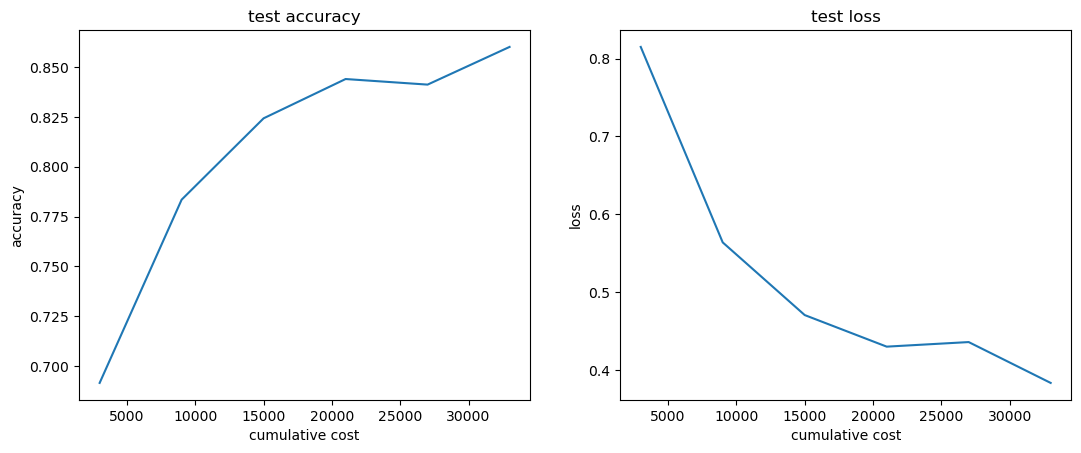

In [6]:
stats = Rsampling.stats

fig, (ax1, ax2)= plt.subplots(1,2, figsize = (12.8,4.8))
ax1.plot(stats['cumul_cost'], stats['acc'])
ax1.set_xlabel('cumulative cost')
ax1.set_ylabel('accuracy')
ax1.set_title('test accuracy')

ax2.plot(stats['cumul_cost'], stats['loss'])
ax2.set_xlabel('cumulative cost')
ax2.set_ylabel('loss')
ax2.set_title('test loss')
plt.show()

## Example 2 - A basic example for Entropy sampling

Entropy sampling only change from Random Sampling only on the acquisition function. We so need to rewrite the *get_batch_examples* from the AL_module. In this example, we do not average the entropies using the bayesian capabilities of the network.

To avoid rewriting the *define_model*, *train* and *test* methods, we use the previous Random_sampling class and override the *get_batch_examples* method.

In [7]:
from torch.distributions import Categorical

class Entropy_sampling(Random_sampling):
    def __init__(self, batch_size, num_epochs, train_data : ALDataset, test_data):
        super().__init__( batch_size, num_epochs, train_data, test_data)
    
    def get_batch_examples(self) :
        loader = DataLoader(Subset(self.train_data, self.train_data.remaining_indices()), shuffle = False, batch_size = self.batch_size, drop_last = False)
        self.model.bayes(False) 
        with torch.no_grad():
            probs = torch.vstack([self.model(inputs.to(self.device)) for inputs, _ , _ in loader])
            probs = F.softmax(probs,  dim=-1)
            entropies = Categorical(probs=probs).entropy().to('cpu')
        return self.train_data.remaining_indices()[ entropies.argsort()[-self.anno_batch_size:] ]

In [8]:
Fashion = FashionMNIST( root = '../../datasets/', train = True , transform=transforms.Compose(
                                                                            [transforms.ToTensor(),
                                                                            transforms.Normalize((0.1307,), (0.3081,)),]
                                                                        ))
Fashion_test = FashionMNIST( root = '../../datasets/', train = False, transform= transforms.Compose(
                                                                        [transforms.ToTensor(),
                                                                        transforms.Normalize((0.1307,), (0.3081,)),]
                                                                        ))

train_data = ALDataset(Fashion, valid_size = 0.)
test_data = ALDataset(Fashion_test)
test_data.true_labels()

Esampling = Entropy_sampling(batch_size = 512, num_epochs = 10, train_data = train_data, test_data = test_data)
Esampling.set_file_name('entropy_sampling_FashionMNIST.pkl')   # must be defined if the ALModule.work method is not overridden
Esampling.work()

initializing AL process
Active Learning step n°1
training substep
Active Learning step n°2
training substep
Active Learning step n°3
training substep
Active Learning step n°4
training substep
Active Learning step n°5
training substep


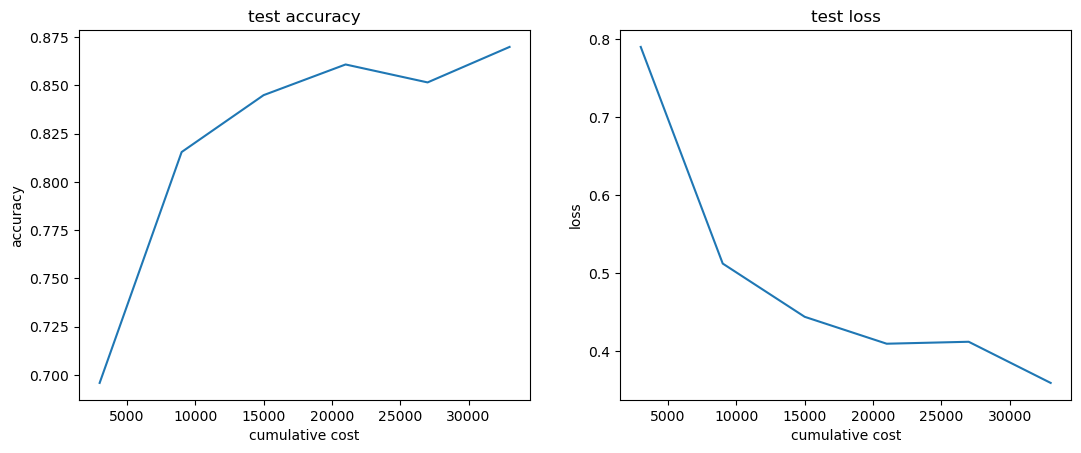

In [9]:
stats = Esampling.stats

fig, (ax1, ax2)= plt.subplots(1,2, figsize = (12.8,4.8))
ax1.plot(stats['cumul_cost'], stats['acc'])
ax1.set_xlabel('cumulative cost')
ax1.set_ylabel('accuracy')
ax1.set_title('test accuracy')

ax2.plot(stats['cumul_cost'], stats['loss'])
ax2.set_xlabel('cumulative cost')
ax2.set_ylabel('loss')
ax2.set_title('test loss')
plt.show()

## Example 3 - Entropy sampling : Uncertainty Sampling

Another solution for Uncertainty Sampling is also directly available in this package. This solution can use the bayesian settings of the networks.
This class needs the get_bayesian_probs, define_model, train, test methods to be implemented

Please note that the *Uncertainty_sampling* class use an argument 'mode'. Moreover, the *get_bayesian_probs* method introduce another int argument (number of iterations for the mean). 

Available mods : 'entropy', 'least confident', 'margin', 'bald', 'random'

In [10]:
class Trainable_uncertainty_sampling(Uncertainty_Sampling):
    def __init__(self, batch_size, num_epochs, train_data : ALDataset, test_data, mode, average):
        super().__init__(train_data,test_data, mode = mode)
        self.average = average
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    def get_bayesian_probs(self):
        '''
        parameters :
        n = self.average

        output : torch.tensor of shape (n, num_unlabeled, num_classes )
        '''
        loader = DataLoader(Subset(self.train_data, self.train_data.remaining_indices()), shuffle = False, 
                            batch_size = self.batch_size, drop_last = False) 
        probs = torch.zeros((self.average, len(self.train_data.remaining_indices()), self.train_data.num_classes))
        
        self.model.eval()                # WARNING : dropouts must be active !
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(device)

        with torch.no_grad():
            for i, (inputs, _, _) in enumerate(loader):
                for t in range(self.average):
                    inputs = inputs.to(device)
                    logits = self.model(inputs)
                    probs[t, i*512:i*512 + len(logits)] =  nn.functional.softmax(logits, dim=-1).to(torch.device('cpu'))
        return probs

    def define_model(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model= ConvNet()
        self.model.to(self.device)
        self.optimizer = Adam(self.model.parameters(), lr = 0.001)
        self.loss = nn.CrossEntropyLoss()

    def train(self):
        train_set = Subset(self.train_data, self.train_data.train_indices())
        loader = DataLoader(train_set, shuffle = True, drop_last = True, batch_size = self.batch_size)
        self.model.train()
        for _ in range(self.num_epochs):
            for inputs, targets, _ in loader :
                self.optimizer.zero_grad()
                inputs = inputs.to(self.device)
                logits = self.model(inputs)
                loss = self.loss(logits, targets.to(self.device))
                loss.backward()
                self.optimizer.step()

    def test(self):
        loader = DataLoader(self.test_data, shuffle = False, drop_last = False, batch_size = self.batch_size)
        test_acc = 0.
        test_loss = 0.
        self.model.bayes(False)       # model in evaluation mod, without bayesian evaluation.
        with torch.no_grad():
            for inputs, targets, _ in loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                logits = self.model(inputs)
                test_acc += (logits.argmax(-1)==targets.argmax(-1)).sum().item()
                loss = self.loss(logits, targets)
                test_loss += loss.item() * len(targets)
        return test_acc / self.test_data.__len__(), test_loss / self.test_data.__len__()
    
    def save(self, file_name):
        '''in this notebook, we don't save the results'''
        pass

    def budget(self):
        return self.stats['cumul_cost'][-1] < 30000
        


In [11]:
Fashion = FashionMNIST( root = '../../datasets/', train = True , transform=transforms.Compose(
                                                                            [transforms.ToTensor(),
                                                                            transforms.Normalize((0.1307,), (0.3081,)),]
                                                                        ))
Fashion_test = FashionMNIST( root = '../../datasets/', train = False, transform= transforms.Compose(
                                                                        [transforms.ToTensor(),
                                                                        transforms.Normalize((0.1307,), (0.3081,)),]
                                                                        ))
train_data = ALDataset(Fashion, valid_size = 0.)
test_data = ALDataset(Fashion_test)
test_data.true_labels()

Esampling_v2 = Trainable_uncertainty_sampling(batch_size = 512, num_epochs = 10, train_data = train_data, test_data = test_data, mode = 'entropy', average = 50)
Esampling_v2.set_file_name('entropy_sampling_FashionMNIST_v2.pkl')   # must be defined if the AL_module.work method is not overridden
Esampling_v2.work()

initializing AL process
Active Learning step n°1
training substep
Active Learning step n°2
training substep
Active Learning step n°3
training substep
Active Learning step n°4
training substep
Active Learning step n°5
training substep


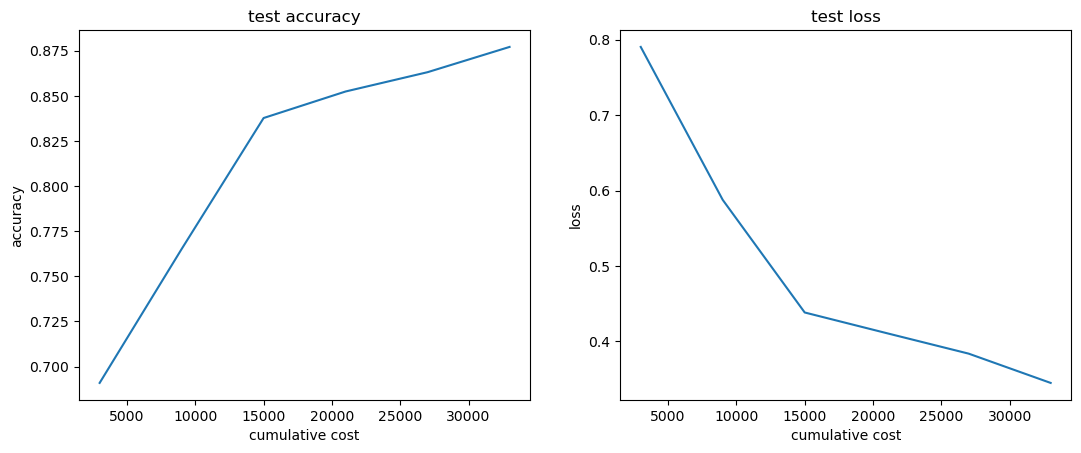

In [12]:
stats = Esampling_v2.stats

fig, (ax1, ax2)= plt.subplots(1,2, figsize = (12.8,4.8))
ax1.plot(stats['cumul_cost'], stats['acc'])
ax1.set_xlabel('cumulative cost')
ax1.set_ylabel('accuracy')
ax1.set_title('test accuracy')

ax2.plot(stats['cumul_cost'], stats['loss'])
ax2.set_xlabel('cumulative cost')
ax2.set_ylabel('loss')
ax2.set_title('test loss')
plt.show()

## Exampe 4 - Coreset : k-center-greedy version

As previously, the *train*, *test*, *define_model* methods must be defined as you want to. The fourth method, which you have to write yourself, is the *get_features* method.


In [13]:
class trainable_Coreset_Greedy(Coreset_Greedy):
    def __init__(self, batch_size, num_epochs, train_data : ALDataset, test_data, metric='euclidean', **kwargs):
        super().__init__( train_data= train_data, test_data = test_data, metric = metric, **kwargs)
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    def get_features(self):
        '''
        Needs to be computed by users
        In this example, my model gives a representation (embedding) of the dataset trough the model.represent method.
        '''
        self.model.eval()
        loader = DataLoader(self.train_data, drop_last=False, batch_size=512, shuffle = False)
        with torch.no_grad():
            features = torch.vstack([self.model.represent(inputs.to(self.device)).cpu() for inputs, _,_ in loader])
        return features

    def define_model(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model= ConvNet()
        self.model.to(self.device)
        self.optimizer = Adam(self.model.parameters(), lr = 0.001)
        self.loss = nn.CrossEntropyLoss()

    def train(self):
        train_set = Subset(self.train_data, self.train_data.train_indices())
        loader = DataLoader(train_set, shuffle = True, drop_last = True, batch_size = self.batch_size)
        self.model.train()
        for _ in range(self.num_epochs):
            for inputs, targets, _ in loader :
                self.optimizer.zero_grad()
                inputs = inputs.to(self.device)
                logits = self.model(inputs)
                loss = self.loss(logits, targets.to(self.device))
                loss.backward()
                self.optimizer.step()

    def test(self):
        loader = DataLoader(self.test_data, shuffle = False, drop_last = False, batch_size = self.batch_size)
        test_acc = 0.
        test_loss = 0.
        self.model.bayes(False)       # model in evaluation mod, without bayesian evaluation.
        with torch.no_grad():
            for inputs, targets, _ in loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                logits = self.model(inputs)
                test_acc += (logits.argmax(-1)==targets.argmax(-1)).sum().item()
                loss = self.loss(logits, targets)
                test_loss += loss.item() * len(targets)
        return test_acc / self.test_data.__len__(), test_loss / self.test_data.__len__()
    
    def save(self, file_name):
        '''in this notebook, we don't save the results'''
        pass

    def budget(self):
        return self.stats['cumul_cost'][-1] < 30000


In [14]:
Fashion = FashionMNIST( root = '../../datasets/', train = True , transform=transforms.Compose(
                                                                            [transforms.ToTensor(),
                                                                            transforms.Normalize((0.1307,), (0.3081,)),]
                                                                        ))
Fashion_test = FashionMNIST( root = '../../datasets/', train = False, transform= transforms.Compose(
                                                                        [transforms.ToTensor(),
                                                                        transforms.Normalize((0.1307,), (0.3081,)),]
                                                                        ))
train_data = ALDataset(Fashion, valid_size = 0.)
test_data = ALDataset(Fashion_test)
test_data.true_labels()

Csampling = trainable_Coreset_Greedy( batch_size= 512, num_epochs = 10, train_data = train_data, test_data = test_data)
Csampling.set_file_name('ello_world.pkl')   # must be defined if the AL_module.work method is not overridden
Csampling.work()


initializing AL process
Active Learning step n°1
training substep
Active Learning step n°2
training substep
Active Learning step n°3
training substep
Active Learning step n°4
training substep
Active Learning step n°5
training substep


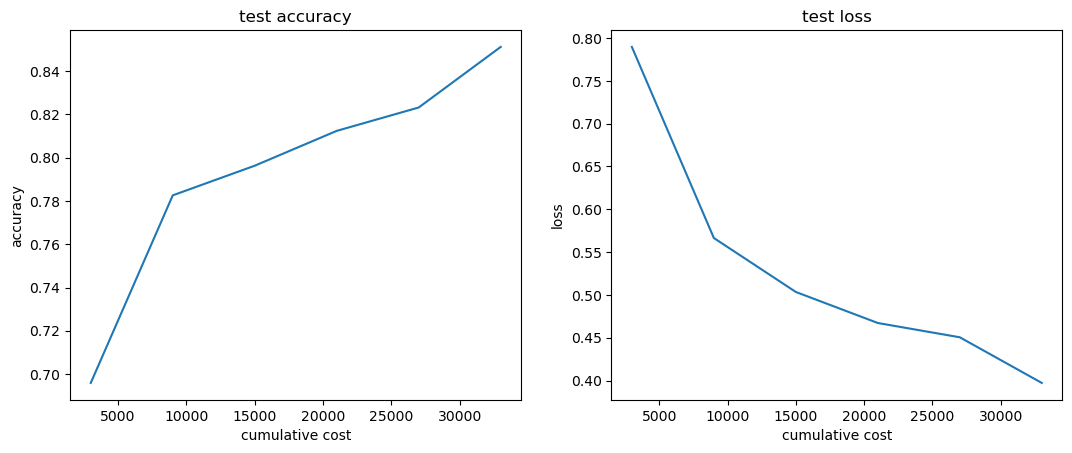

In [15]:

stats = Csampling.stats

fig, (ax1, ax2)= plt.subplots(1,2, figsize = (12.8,4.8))
ax1.plot(stats['cumul_cost'], stats['acc'])
ax1.set_xlabel('cumulative cost')
ax1.set_ylabel('accuracy')
ax1.set_title('test accuracy')

ax2.plot(stats['cumul_cost'], stats['loss'])
ax2.set_xlabel('cumulative cost')
ax2.set_ylabel('loss')
ax2.set_title('test loss')
plt.show()


## Example 5 - ALPF Active Learning with Partial feedback

In this example, we implement an ALPF algortihm, whose acquisition function maximize the Expected Information Gain, and  based on a set of coarse-grained classes, produced randomly. 

We also define distinct costs of annotation, based on the fact that asking for a coarse-grained class is cheaper than asking for a fine-grained class.

The previous *train* method is not modified. We just need to consider a loss adapted to partial labels.

In [16]:
from ALprocesses import ALPF

class trainable_ALPF(ALPF):
    def __init__(self, batch_size, num_epochs, train_data : ALDataset, test_data, Q : torch.Tensor, l_cost = 0., mode ='eig', **kwargs):
        super().__init__(train_data = train_data, test_data = test_data, Q = Q, l_cost = l_cost, mode = mode, **kwargs)
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    def partial_loss(self, output : torch.Tensor, target : torch.Tensor):
        """
        target: binary encoding of partial labels
        """
        output_prob = nn.functional.softmax(output, dim=-1)
        prob = torch.sum(1e-12+output_prob * target, -1)
        log_prob = torch.log(prob) # / target.sum(-1)
        return torch.mean(-log_prob)
    
    def cost(self, idx=None):
        if idx is None :
            return np.array([1])
        elif self.Q[idx].sum() == 1 :
            return 1.
        elif self.Q[idx].sum() < self.train_data.num_classes :
            return 0.5
        else :
            return 0.

    def get_probs(self):
        my_set = Subset(self.train_data, self.train_data.remaining_indices())
        loader = DataLoader(my_set, shuffle = False, drop_last = False, batch_size = self.batch_size)
        self.model.bayes(False)
        probs = torch.zeros((len(self.train_data.remaining_indices()), self.train_data.num_classes))
        with torch.no_grad():
            for i, (inputs, _,_) in enumerate(loader) :
                logit = self.model(inputs.to(self.device))
                probs[i*self.batch_size:(i+1)*self.batch_size, :] = F.softmax(logit.to('cpu'), dim=-1)
        return probs
    
    def define_model(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model= ConvNet()
        self.model.to(self.device)
        self.optimizer = Adam(self.model.parameters(), lr = 0.001)
        self.loss = self.partial_loss

    def train(self):
        train_set = Subset(self.train_data, self.train_data.train_indices())
        loader = DataLoader(train_set, shuffle = True, drop_last = True, batch_size = self.batch_size)
        self.model.train()
        for _ in range(self.num_epochs):
            for inputs, targets, _ in loader :
                self.optimizer.zero_grad()
                inputs = inputs.to(self.device)
                logits = self.model(inputs)
                loss = self.loss(logits, targets.to(self.device))
                loss.backward()
                self.optimizer.step()

    def test(self):
        loader = DataLoader(self.test_data, shuffle = False, drop_last = False, batch_size = self.batch_size)
        test_acc = 0.
        test_loss = 0.
        self.model.bayes(False)       # model in evaluation mod, without bayesian evaluation.
        with torch.no_grad():
            for inputs, targets, _ in loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                logits = self.model(inputs)
                test_acc += (logits.argmax(-1)==targets.argmax(-1)).sum().item()
                loss = self.loss(logits, targets)
                test_loss += loss.item() * len(targets)
        return test_acc / self.test_data.__len__(), test_loss / self.test_data.__len__()
    
    def save(self, file_name):
        '''in this notebook, we don't save the results'''
        pass

    def budget(self):
        return self.stats['cumul_cost'][-1] < 30000

    

In [17]:

Q = np.vstack( (np.random.binomial(1,1/3,(100,10)), np.random.binomial(1,2/3,(100,10))) )
Q = torch.from_numpy(Q)
Q2 = Q[0].reshape(1,-1).tolist()
for q in Q:
    if q.tolist() not in Q2 :
        Q2.append(q.tolist())
Q = torch.tensor(Q2)

In [18]:

Fashion = FashionMNIST( root = '../../datasets/', train = True , transform=transforms.Compose(
                                                                            [transforms.ToTensor(),
                                                                            transforms.Normalize((0.1307,), (0.3081,)),]
                                                                        ))
Fashion_test = FashionMNIST( root = '../../datasets/', train = False, transform= transforms.Compose(
                                                                        [transforms.ToTensor(),
                                                                        transforms.Normalize((0.1307,), (0.3081,)),]
                                                                        ))

train_data = ALDataset(Fashion, valid_size = 0.)
test_data = ALDataset(Fashion_test)
test_data.true_labels()

alpf = trainable_ALPF( batch_size = 512, num_epochs = 10, train_data = train_data , test_data= test_data, Q =Q , l_cost = 0.1, mode ='eig' )
print('annotation batch size', alpf.anno_batch_size)
alpf.set_file_name('ello_world.pkl')
alpf.work()


annotation batch size 6000
initializing AL process
Active Learning step n°1
training substep
Active Learning step n°2
training substep
Active Learning step n°3
training substep
Active Learning step n°4
training substep
Active Learning step n°5
training substep
Active Learning step n°6
training substep
Active Learning step n°7
training substep
Active Learning step n°8
training substep
Active Learning step n°9
training substep


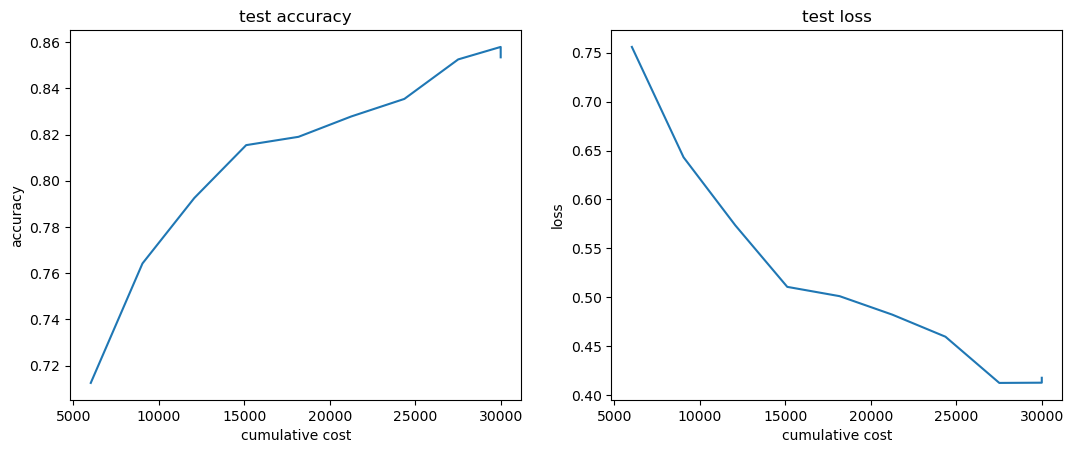

In [19]:
stats = alpf.stats

fig, (ax1, ax2)= plt.subplots(1,2, figsize = (12.8,4.8))
ax1.plot(stats['cumul_cost'], stats['acc'])
ax1.set_xlabel('cumulative cost')
ax1.set_ylabel('accuracy')
ax1.set_title('test accuracy')

ax2.plot(stats['cumul_cost'], stats['loss'])
ax2.set_xlabel('cumulative cost')
ax2.set_ylabel('loss')
ax2.set_title('test loss')
plt.show()

In [20]:
t = Q.sum(-1)
ina = np.where(t ==10)
full = np.where(t==1)
partial = np.where((t > 1) * (t<10))

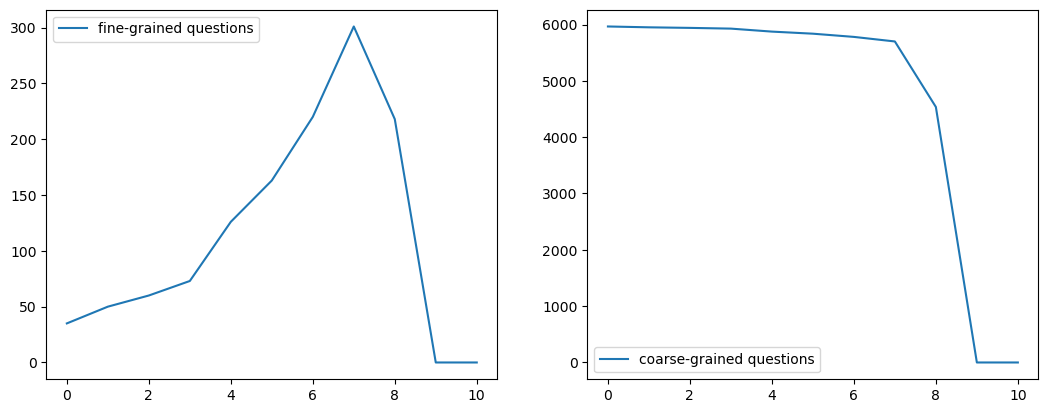

In [21]:
temp = {'ina' :[0],
        'full' :[0],
        'partial' :[0]}
for questions in alpf.stats['questions']:
    for q in questions:
        if q in ina[0]:
            temp['ina'][-1] +=1
        elif q in full[0] :
            temp['full'][-1]+=1
        else :
            temp['partial'][-1]+=1
    for key in temp.keys():
        temp[key].append(0)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12.8,4.8))
ax1.plot(np.arange(len(temp['full'])), temp['full'], label = 'fine-grained questions')
ax1.legend()
ax2.plot(np.arange(len(temp['partial'])), temp['partial'], label ='coarse-grained questions')
ax2.legend()
plt.show()